## Applicazione analisi Detection Histories e Modelli Occupancy per intero 2018

### Claudia Gabriela Ochoa Martinez (2020)

In [1]:
#### Inserire l'anno su cui si vuole effettuare l'analisi es. =="2014", "2015", ecc
anno_analisi <- "2018"
#sessione_analisi <- "1"

In [2]:
library(dplyr)
library(MASS)
library(readr)
library(unmarked)
require(stats4)
require(parallel)
library(stringi)
#library(MuMIn)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: lattice

Loading required package: stats4


Attaching package: 'stats4'


The following object is masked from 'package:unmarked':

    mle


Loading required package: parallel



In [3]:
# Matrice di detection history (catture effettive) -- y
catture_effettive <- read.csv("Dati-preparazione-modello\\catture_effettive_totale.csv", dec=",", sep=";", header = TRUE)

# Leggiamo le matrici dell'Orario (Alba Tramonto), Precipitazioni e Temperatura -- ObsCovs
orario_occasione <- read.csv("Dati-preparazione-modello\\orario_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
precipitazioni_occasione <- read.csv("Dati-preparazione-modello\\precipitazioni_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
temperatura_occasione <- read.csv("Dati-preparazione-modello\\temperatura_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)
velvento_occasione <- read.csv("Dati-preparazione-modello\\velvento_occasione_totale.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

# Prendiamo Datioccas per legare l'anno alle varie osservazioni
Datioccas <- read.csv("Dati-elaborati/Dati-occasioni.csv", dec=",", sep=";", header = TRUE)

# Leggiamo il file relativo alle invarianti ambientali (covariate) -- siteCovs
siteCovs_orig <- read.csv("Dati-preparazione-modello/Dati-cov-mdr-iqr.csv", dec=",", sep=";", header = TRUE, stringsAsFactors = FALSE)

In [4]:
# Non avendo sufficienti dati sulle ultime 5 trappole, le escludiamo
catture_effettive <- catture_effettive[1:70,]

orario_occasione <- orario_occasione[1:70,]
precipitazioni_occasione <- precipitazioni_occasione[1:70,]
temperatura_occasione <- temperatura_occasione[1:70,]
velvento_occasione <- velvento_occasione[1:70,]
siteCovs_orig <- siteCovs_orig[1:70,]

In [5]:
precipitazioni_occasione <- ceiling(precipitazioni_occasione)

In [6]:
# Seleziono la coperatura vegetale di interesse
if (anno_analisi %in% c("2014","2015","2016","2017")) {
    siteCovs_orig$cop_veg_ottavi <- siteCovs_orig$Cop_Veg_2015_ottavi
    siteCovs_orig <- subset(siteCovs_orig, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))
} else {
    siteCovs_orig$cop_veg_ottavi <- siteCovs_orig$Cop_Veg_2018_ottavi
    siteCovs_orig <- subset(siteCovs_orig, select=-c(Cop_Veg_2015_ottavi,Cop_Veg_2018_ottavi))

}

In [7]:
# Lasciamo solo 3 categorie
siteCovs_orig$dominant[siteCovs_orig$dominant != "Graminacee" & siteCovs_orig$dominant != "Muschio"]  <- "Other_Sp"

siteCovs <- siteCovs_orig # Conserviamo i dati originali prima di trasformare in numeric e scalare

# TRASFORMIAMO le specie vegetali presenti in siteCovs in numeric per evitare singolarità nei modelli
# siteCovs$dominant[siteCovs$dominant != "Graminacee" & siteCovs$dominant != "Muschio"]  <- 30
# siteCovs$dominant[siteCovs$dominant == "Graminacee"]  <- 20
# siteCovs$dominant[siteCovs$dominant == "Muschio"]  <- 10
# siteCovs$dominant <- as.numeric(siteCovs$dominant)

# PROVIAMO COME FACTOR MANTENENDO I VALORI CATEGORICI
siteCovs$dominant <- as.factor(siteCovs$dominant)

tail(siteCovs)

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,dominant,MDR,IQR,Esp.tr,cop_veg_ottavi
,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<dbl>,<int>,<int>
65,292,99,67,2787.358,13,7,2,Muschio,99,112.5,13,NA
66,139,75,21,2788.498,11,29,14,Other_Sp,75,59.0,11,NA
67,77,83,40,2792.428,19,38,13,Graminacee,77,21.5,19,NA
68,71,127,58,2794.777,13,17,10,Other_Sp,71,34.5,13,NA
69,97,75,66,2792.266,12,11,8,Graminacee,75,15.5,12,NA
70,207,73,96,2792.857,358,2,2,Other_Sp,96,67.0,-2,NA


In [8]:
# Ricaviamo le colonne oggetto di analisi
if (exists("sessione_analisi")) {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi & sessione == sessione_analisi))
} else {
    colonne_oggetto_analisi <- rownames(subset(Datioccas,Anno == anno_analisi))
}
colonne_oggetto_analisi <- as.numeric(colonne_oggetto_analisi)
#colonne_oggetto_analisi <- c(1:100)


In [9]:
catture_effettive_selezionate <- catture_effettive[,colonne_oggetto_analisi]

In [10]:
summary(siteCovs)

 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   : 30.00         Min.   : 28.00         Min.   :  8.00        
 1st Qu.: 67.25         1st Qu.: 44.00         1st Qu.: 40.00        
 Median : 97.00         Median : 62.00         Median : 56.50        
 Mean   :118.70         Mean   : 75.06         Mean   : 69.66        
 3rd Qu.:139.75         3rd Qu.: 92.50         3rd Qu.: 75.50        
 Max.   :440.00         Max.   :308.00         Max.   :292.00        
                                                                     
     alt_m        aspect_deg      slope_degr      n_species           dominant 
 Min.   :2778   Min.   :  0.0   Min.   : 0.00   Min.   : 0.00   Graminacee:39  
 1st Qu.:2783   1st Qu.: 59.0   1st Qu.: 7.25   1st Qu.:10.25   Muschio   :15  
 Median :2789   Median :314.5   Median :11.50   Median :15.00   Other_Sp  :16  
 Mean   :2789   Mean   :239.4   Mean   :13.04   Mean   :15.59                  
 3rd Qu.:2795   3rd Qu.:332.0   3rd Qu.:

#### Concludiamo che tutte le variabili presenti in siteCovs sono adatte ad essere utilizzate nell'analisi
#### Provvediamo a scalarle e centrarle

In [11]:
siteCovs_scaled <- scale(siteCovs[names(siteCovs) != "dominant"])
head(siteCovs_scaled)
dominant <- siteCovs$dominant
siteCovs <- cbind(as.data.frame(siteCovs_scaled),dominant)
head(siteCovs)
attr(siteCovs_scaled, 'scaled:scale')

,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,MDR,IQR,Esp.tr,cop_veg_ottavi
1,-0.7999612,0.4449731,0.6121266,-0.9638930,-0.03990354,-0.004945912,0.97220994,0.65969346,-0.7248291,-2.7977585,1.3660940
2,0.7678020,-0.7023655,0.1200460,-1.1064717,0.39997796,0.341267903,0.05432387,0.05605239,0.4943843,-1.1704790,-0.3135298
3,-0.9071587,0.2749970,-0.1449204,-1.1156660,0.51727969,-1.505205774,-0.33905587,-0.36649637,-0.8052168,-0.7365377,-0.3135298
4,-0.2639738,-0.9573296,-0.6370010,-1.1130010,0.39264660,-0.581968936,0.97220994,-1.15122977,-0.3764824,-1.1976003,1.3660940
5,0.6070058,-0.7236125,-0.4288130,-1.0064001,0.39997796,-0.235755121,0.70995678,-0.81922717,0.3470069,-1.1704790,-0.3135298
6,0.1514164,-0.9360826,-0.6370010,-0.9597622,0.51727969,-0.697373540,0.57883019,-1.15122977,0.0254561,-0.7365377,0.8062194


,Diametro.roccia.1..cm.,Diametro.roccia.2..cm.,Diametro.roccia.3..cm.,alt_m,aspect_deg,slope_degr,n_species,MDR,IQR,Esp.tr,cop_veg_ottavi,dominant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-0.7999612,0.4449731,0.6121266,-0.9638930,-0.03990354,-0.004945912,0.97220994,0.65969346,-0.7248291,-2.7977585,1.3660940,Graminacee
2,0.7678020,-0.7023655,0.1200460,-1.1064717,0.39997796,0.341267903,0.05432387,0.05605239,0.4943843,-1.1704790,-0.3135298,Graminacee
3,-0.9071587,0.2749970,-0.1449204,-1.1156660,0.51727969,-1.505205774,-0.33905587,-0.36649637,-0.8052168,-0.7365377,-0.3135298,Graminacee
4,-0.2639738,-0.9573296,-0.6370010,-1.1130010,0.39264660,-0.581968936,0.97220994,-1.15122977,-0.3764824,-1.1976003,1.3660940,Graminacee
5,0.6070058,-0.7236125,-0.4288130,-1.0064001,0.39997796,-0.235755121,0.70995678,-0.81922717,0.3470069,-1.1704790,-0.3135298,Graminacee
6,0.1514164,-0.9360826,-0.6370010,-0.9597622,0.51727969,-0.697373540,0.57883019,-1.15122977,0.0254561,-0.7365377,0.8062194,Graminacee


Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm. 
             74.628617              47.065445              52.836879 
                 alt_m             aspect_deg             slope_degr 
              7.504627             136.400374               8.665166 
             n_species                    MDR                    IQR 
              7.626219              33.132271              37.319144 
                Esp.tr         cop_veg_ottavi 
             36.871353               1.786114

In [12]:
summary(t(orario_occasione[1,colonne_oggetto_analisi]))
summary(t(precipitazioni_occasione[1,colonne_oggetto_analisi]))
summary(t(temperatura_occasione[1,colonne_oggetto_analisi]))
summary(t(velvento_occasione[1,colonne_oggetto_analisi]))


      1            
 Length:35         
 Class :character  
 Mode  :character  

       1          
 Min.   :0.00000  
 1st Qu.:0.00000  
 Median :0.00000  
 Mean   :0.05714  
 3rd Qu.:0.00000  
 Max.   :1.00000  

       1        
 Min.   : 4.20  
 1st Qu.: 9.65  
 Median :12.60  
 Mean   :11.82  
 3rd Qu.:14.20  
 Max.   :17.40  

       1        
 Min.   :0.000  
 1st Qu.:1.000  
 Median :1.400  
 Mean   :1.531  
 3rd Qu.:1.950  
 Max.   :3.800  

#### La variabile relativa alle precipitazioni, nel 2015, è inadatta alle analisi, verrà automaticamente scartata dal modello
#### Le variabili categoriche non possono essere scalate (orario_ooccasione)
#### La variabile temperatura_occasione è inadatta ad essere scalata

In [13]:
obsCovs <- list(
    orario = orario_occasione[,colonne_oggetto_analisi],
    precip = (((precipitazioni_occasione[,colonne_oggetto_analisi]))),
    temper = (((temperatura_occasione[,colonne_oggetto_analisi]))),
    vento = (((velvento_occasione[,colonne_oggetto_analisi])))

)
#lapply(obsCovs,summary)

In [14]:
arvicole <- unmarkedFrameOccu(y = catture_effettive_selezionate, siteCovs = siteCovs, obsCovs = obsCovs)
summary(arvicole)

Warning message:
"obsCovs contains characters. Converting them to factors."


unmarkedFrame Object

70 sites
Maximum number of observations per site: 35 
Mean number of observations per site: 35 
Sites with at least one detection: 27 

Tabulation of y observations:
   0    1 
2391   59 

Site-level covariates:
 Diametro.roccia.1..cm. Diametro.roccia.2..cm. Diametro.roccia.3..cm.
 Min.   :-1.1886        Min.   :-0.9998        Min.   :-1.1669       
 1st Qu.:-0.6894        1st Qu.:-0.6599        1st Qu.:-0.5613       
 Median :-0.2908        Median :-0.2774        Median :-0.2490       
 Mean   : 0.0000        Mean   : 0.0000        Mean   : 0.0000       
 3rd Qu.: 0.2821        3rd Qu.: 0.3706        3rd Qu.: 0.1106       
 Max.   : 4.3053        Max.   : 4.9493        Max.   : 4.2081       
                                                                     
     alt_m            aspect_deg        slope_degr        n_species      
 Min.   :-1.53434   Min.   :-1.7554   Min.   :-1.5052   Min.   :-2.0437  
 1st Qu.:-0.91819   1st Qu.:-1.3229   1st Qu.:-0.6685   1s

In [15]:
# (siteCovs(arvicole))
# (obsCovs(arvicole))

In [16]:
# n_species potremmo ignorarlo poiché fortemente correlato con la copertura veg. del 2015
# slope_degr potremmo ignorarlo ignorato poiché trasformato in Esp.tr
#    occu(~P            # PROBABILITA' DI AVVISTAMENTO
#         ~PSI,         # EFFETTIVA PRESENZA
#          dataset)
start_value <- c(1,3,-1,5,2,1,-3,5,0.5,-1)
fm.base <- occu(
    ~orario + temper  + MDR  + vento + precip
    ~dominant +
     alt_m + I(alt_m^2) +
     cop_veg_ottavi + I(cop_veg_ottavi^2) +
     Esp.tr + I(Esp.tr^2)+
     IQR + I(IQR^2) +
     MDR + I(MDR^2) + 
     slope_degr + I(slope_degr^2),
    arvicole, 
    control = list(trace=0, maxit=1e7),
   #starts=start_value
)

# fm.base <- occu(~orario + temper  + MDR  + vento ~ dominant + MDR + slope_degr + alt_m + cop_veg_ottavi + Esp.tr + n_species, arvicole, control = list(trace=0, maxit=1e5))
 fm.base

Warning message:
"Some observations have been discarded because corresponding covariates were missing."
Warning message:
"20 sites have been discarded because of missing data."
Warning message:
"Hessian is singular. Try providing starting values or using fewer covariates."



Call:
occu(formula = ~orario + temper + MDR + vento + precip ~ dominant + 
    alt_m + I(alt_m^2) + cop_veg_ottavi + I(cop_veg_ottavi^2) + 
    Esp.tr + I(Esp.tr^2) + IQR + I(IQR^2) + MDR + I(MDR^2) + 
    slope_degr + I(slope_degr^2), data = arvicole, control = list(trace = 0, 
    maxit = 1e+07))

Occupancy:
                    Estimate SE  z P(>|z|)
(Intercept)            166.1 NA NA      NA
dominantMuschio        119.3 NA NA      NA
dominantOther_Sp       154.8 NA NA      NA
alt_m                  -77.0 NA NA      NA
I(alt_m^2)             -96.8 NA NA      NA
cop_veg_ottavi        -127.5 NA NA      NA
I(cop_veg_ottavi^2)   -196.2 NA NA      NA
Esp.tr                  32.3 NA NA      NA
I(Esp.tr^2)           -100.1 NA NA      NA
IQR                    183.3 NA NA      NA
I(IQR^2)               115.6 NA NA      NA
MDR                    -38.5 NA NA      NA
I(MDR^2)               -47.8 NA NA      NA
slope_degr             -26.0 NA NA      NA
I(slope_degr^2)        233.2 NA NA      NA

In [17]:
######### INFORMATICA
if (exists("clust")) stopCluster(clust)
clusterType <- if(length(find.package("snow", quiet = TRUE))) "SOCK" else "PSOCK"
clusterType
clust <- try(makeCluster(getOption("cl.cores", 12), type = clusterType))
clusterEvalQ(clust, library(unmarked))
clusterEvalQ(clust,library(MuMIn))
clusterExport(clust, "arvicole")
invisible(clusterCall(clust, "library", "stats4", character.only = TRUE))
library(MuMIn)
getAllTerms(fm.base)

[1] "SOCK"

[[1]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[7]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[8]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[9]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[10]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[11]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"     

[[12]]
 [1] "unmarked"  "lattice"   "snow"      "stats"     "graphics"  "grDevices"
 [7] "utils"     "datasets"  "methods"   "base"

[[1]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[6]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[7]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[8]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[9]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[10]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[11]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[12]]
 [1] "MuMIn"     "unmarked"  "lattice"   "snow"      "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"

[1] "p(MDR)"                   "p(orario)"               
 [3] "p(precip)"                "p(temper)"               
 [5] "p(vento)"                 "psi(alt_m)"              
 [7] "psi(I(alt_m^2))"          "psi(cop_veg_ottavi)"     
 [9] "psi(I(cop_veg_ottavi^2))" "psi(dominant)"           
[11] "psi(Esp.tr)"              "psi(I(Esp.tr^2))"        
[13] "psi(IQR)"                 "psi(I(IQR^2))"           
[15] "psi(MDR)"                 "psi(I(MDR^2))"           
[17] "psi(slope_degr)"          "psi(I(slope_degr^2))"    
attr(,"intercept")
  p psi 
  1   1 
attr(,"interceptLabel")
[1] "p(Int)"   "psi(Int)"
attr(,"deps")
                         p(MDR) p(orario) p(precip) p(temper) p(vento)
p(MDR)                       NA     FALSE     FALSE     FALSE    FALSE
p(orario)                 FALSE        NA     FALSE     FALSE    FALSE
p(precip)                 FALSE     FALSE        NA     FALSE    FALSE
p(temper)                 FALSE     FALSE     FALSE        NA    FALSE
p(vento)                  FALSE     FALSE     FALSE     FALSE       NA
psi(alt_m)                FALSE     FALSE     FALSE     FALSE    FALSE
psi(I(alt_m^2))           FALSE     FALSE     FALSE     FALSE    FALSE
psi(cop_veg_ottavi)       FALSE     FALSE     FALSE     FALSE    FALSE
psi(I(cop_veg_ottavi^2))  FALSE     FALSE     FALSE     FALSE    FALSE
psi(dominant)             FALSE     FALSE     FALSE     FALSE    FALSE
psi(Esp.tr)               FALSE     FALSE     FALSE     FALSE    FALSE
psi(I(Esp.tr^2))          FALSE     FALSE     FALSE     FALSE    FALSE
psi(IQR)                  FALSE     FALSE     FALSE     FALSE    FALSE
psi(I(IQR^2))             FALSE     FALSE     FALSE     FALSE    FALSE
psi(MDR)                  FALSE     FALSE     FALSE     FALSE    FALSE
psi(I(MDR^2))             FALSE     FALSE     FALSE     FALSE    FALSE
psi(slope_degr)           FALSE     FALSE     FALSE     FALSE    FALSE
psi(I(slope_degr^2))      FALSE     FALSE     FALSE     FALSE    FALSE
                         psi(alt_m) psi(I(alt_m^2)) psi(cop_veg_ottavi)
p(MDR)                        FALSE           FALSE               FALSE
p(orario)                     FALSE           FALSE               FALSE
p(precip)                     FALSE           FALSE               FALSE
p(temper)                     FALSE           FALSE               FALSE
p(vento)                      FALSE           FALSE               FALSE
psi(alt_m)                       NA           FALSE               FALSE
psi(I(alt_m^2))               FALSE              NA               FALSE
psi(cop_veg_ottavi)           FALSE           FALSE                  NA
psi(I(cop_veg_ottavi^2))      FALSE           FALSE               FALSE
psi(dominant)                 FALSE           FALSE               FALSE
psi(Esp.tr)                   FALSE           FALSE               FALSE
psi(I(Esp.tr^2))              FALSE           FALSE               FALSE
psi(IQR)                      FALSE           FALSE               FALSE
psi(I(IQR^2))                 FALSE           FALSE               FALSE
psi(MDR)                      FALSE           FALSE               FALSE
psi(I(MDR^2))                 FALSE           FALSE               FALSE
psi(slope_degr)               FALSE           FALSE               FALSE
psi(I(slope_degr^2))          FALSE           FALSE               FALSE
                         psi(I(cop_veg_ottavi^2)) psi(dominant) psi(Esp.tr)
p(MDR)                                      FALSE         FALSE       FALSE
p(orario)                                   FALSE         FALSE       FALSE
p(precip)                                   FALSE         FALSE       FALSE
p(temper)                                   FALSE         FALSE       FALSE
p(vento)                                    FALSE         FALSE       FALSE
psi(alt_m)                                  FALSE         FALSE       FALSE
psi(I(alt_m^2))                             FALSE         FALSE       FALSE
psi(cop_veg_ottavi)                         

In [18]:

msubset <- expression(
    `psi(dominant)` &
     dc(`psi(alt_m)`,`psi(I(alt_m^2))`) & 
     dc(`psi(cop_veg_ottavi)`,`psi(I(cop_veg_ottavi^2))`) &
     dc(`psi(Esp.tr)`,`psi(I(Esp.tr^2))`) & 
     dc(`psi(IQR)`,`psi(I(IQR^2))`) &
     dc(`psi(MDR)`,`psi(I(MDR^2))`) & 
     dc(`psi(slope_degr)`,`psi(I(slope_degr^2))`) &
    `p(MDR)` &  `p(orario)` & `p(temper)` & `p(vento)` & `p(precip)`
)

# multimodel <- dredge(fm.base, subset = msubset, trace=1, m.lim = c(1,NA))
multimodel <- pdredge(fm.base, clust,
                      subset = msubset,
                      trace=2,
                      m.lim = c(1,NA)
                     )


Fixed terms are "p(Int)" and "psi(Int)"



  |======================================================================| 100%


In [23]:
head(multimodel)

Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"
Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"
Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"
Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"


,p(Int),psi(Int),p(MDR),p(orario),p(precip),p(temper),p(vento),psi(alt_m),psi(I(alt_m^2)),psi(cop_veg_ottavi),...,psi(I(IQR^2)),psi(MDR),psi(I(MDR^2)),psi(slope_degr),psi(I(slope_degr^2)),df,logLik,AICc,delta,weight
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
5023,-3.841263,38.63583,-0.11983522,+,0.5692597,0.004350417,0.3029813,NA,NA,-55.97245,...,NA,NA,NA,NA,NA,12,-230.9843,494.4010,0.000000,0.35640694
87743,-3.760819,-87.14714,-0.17356466,+,0.5713280,0.004418010,0.3027722,-86.42286,NA,-140.14326,...,NA,119.99215,NA,-107.60794,NA,15,-225.9519,496.0214,1.620402,0.15851862
767,-3.839036,-13.59147,-0.14891423,+,0.5682627,0.004320714,0.3029342,-30.53500,-5.436842,-16.18217,...,NA,NA,NA,NA,NA,12,-231.8718,496.1761,1.775083,0.14672083
66303,-3.835545,-12.34705,-0.11734351,+,0.5700098,0.004340278,0.3014344,-24.22234,-7.777883,-35.63506,...,NA,NA,NA,-25.34306,NA,13,-230.1516,496.4143,2.013247,0.13024922
5055,-3.830707,4.14275,-0.16139308,+,0.5587371,0.004192432,0.3069918,-10.12454,NA,-18.28076,...,NA,NA,NA,NA,NA,13,-230.2000,496.5112,2.110130,0.12409015
49919,-3.815068,-20.59523,-0.06580293,+,0.5702312,0.004392708,0.3016165,-80.43539,-16.106031,-43.12208,...,NA,15.21702,-8.666574,NA,NA,14,-228.6456,497.2912,2.890174,0.08401424


Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"
Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"
Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"
Warning message in `[.model.selection`(a, , part_c$end, drop = FALSE):
"cannot recalculate "weights" on an incomplete object"


,p(Int),psi(Int),p(MDR),p(orario),p(precip),p(temper),p(vento),psi(alt_m),psi(I(alt_m^2)),psi(cop_veg_ottavi),...,psi(I(IQR^2)),psi(MDR),psi(I(MDR^2)),psi(slope_degr),psi(I(slope_degr^2)),df,logLik,AICc,delta,weight
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
5023,-3.841263,38.63583,-0.11983522,+,0.5692597,0.004350417,0.3029813,NA,NA,-55.97245,...,NA,NA,NA,NA,NA,12,-230.9843,494.4010,0.000000,0.35640694
87743,-3.760819,-87.14714,-0.17356466,+,0.5713280,0.004418010,0.3027722,-86.42286,NA,-140.14326,...,NA,119.99215,NA,-107.60794,NA,15,-225.9519,496.0214,1.620402,0.15851862
767,-3.839036,-13.59147,-0.14891423,+,0.5682627,0.004320714,0.3029342,-30.53500,-5.436842,-16.18217,...,NA,NA,NA,NA,NA,12,-231.8718,496.1761,1.775083,0.14672083
66303,-3.835545,-12.34705,-0.11734351,+,0.5700098,0.004340278,0.3014344,-24.22234,-7.777883,-35.63506,...,NA,NA,NA,-25.34306,NA,13,-230.1516,496.4143,2.013247,0.13024922
5055,-3.830707,4.14275,-0.16139308,+,0.5587371,0.004192432,0.3069918,-10.12454,NA,-18.28076,...,NA,NA,NA,NA,NA,13,-230.2000,496.5112,2.110130,0.12409015
49919,-3.815068,-20.59523,-0.06580293,+,0.5702312,0.004392708,0.3016165,-80.43539,-16.106031,-43.12208,...,NA,15.21702,-8.666574,NA,NA,14,-228.6456,497.2912,2.890174,0.08401424


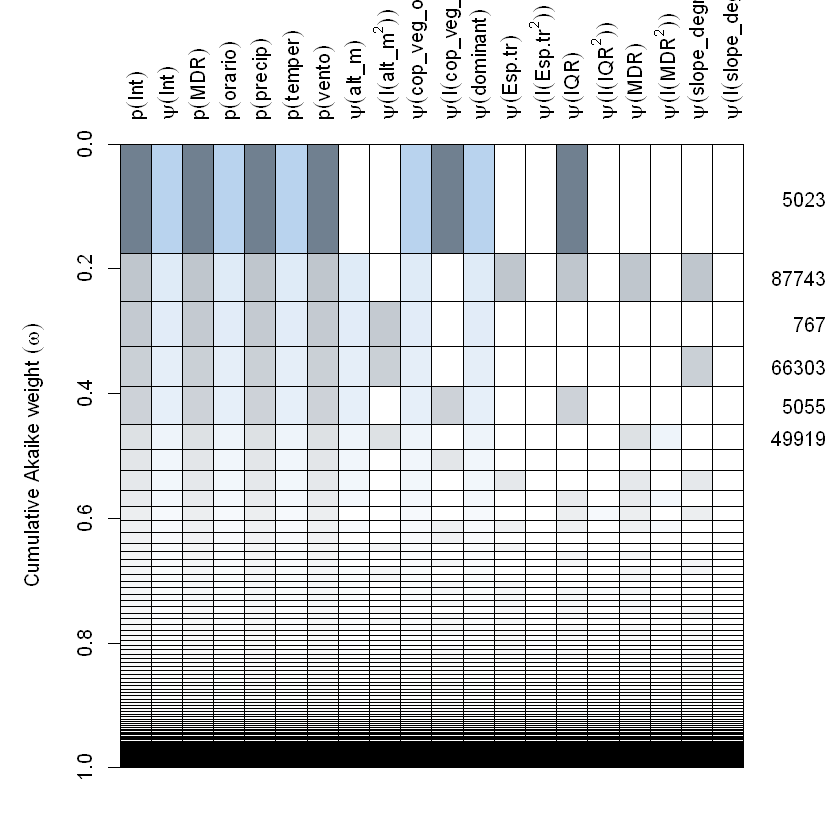

In [20]:
head(multimodel)
par(mfrow = c(1,1))
op <- par(mar = c(3,5,6,4), mfrow=c(1,1))
plot(multimodel, labAsExpr = TRUE)
par(op)


In [21]:
if (exists("sessione_analisi")) {
    save(list=c("multimodel", "arvicole", "siteCovs_orig","siteCovs_scaled"), file=paste0("Dati-modelli/multimodel_", anno_analisi,"_sessione_",sessione_analisi,"_",stri_rand_strings(1, 4, '[A-Z0-9]'),".RData"), compress=FALSE)
} else {
    save(list=c("multimodel", "arvicole", "siteCovs_orig","siteCovs_scaled"), file=paste0("Dati-modelli/multimodel_", anno_analisi,"_",stri_rand_strings(1, 4, '[A-Z0-9]'),".RData"), compress=FALSE)
}